In [6]:
from bs4 import BeautifulSoup
import cartopy
from lat_lon_parser import parse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from mappings import (labels_map, seas_map, countries_map, status_map)

%matplotlib notebook
%load_ext autoreload
%autoreload 2

URL_de = "https://de.wikipedia.org/wiki/Liste_der_Offshore-Windparks"
URL_en = "https://en.wikipedia.org/wiki/List_of_offshore_wind_farms"

def get_table(url, table=0):
    response=requests.get(url)
    if response.status_code != 200:
        print(f'failed to request data: {response.status_code}')
    soup = BeautifulSoup(response.text, 'html.parser')
    windfarm_table=soup.find('table',{'class':"wikitable"})
    df = pd.read_html(str(windfarm_table).replace(",", "."))
    df = pd.DataFrame(df[table])
    return df

def find_headers(df, verbose=False):
    for i, row in df.iterrows():
        if row.Meer == row.Staat:
            if verbose:
                print(f'duplicate entries: {row.Meer}')
            yield i

def convert_lat_lon(df, coord_column_name="coordinates"):
    lats = list()
    lons = list()
    for coords in df[coord_column_name]:
        lat, lon = coords.replace("\xa0", "").split(".")
        lats.append(parse(lat))
        lons.append(parse(lon))
        
    df.insert(loc=len(df.columns), value=lats, column='latitude')
    df.insert(loc=len(df.columns), value=lons, column='longitude')
    #df.insert()

def replace_parenthesis(x):
    try:
        return x.replace("(", "").replace(")", "")
    except:
        return x
    
def replace_german_float(x, verbose=False):
    xr = x.replace(",", ".")
    print(f"replaced: {x} -> {xr}")
    try:
        return float(xr)
    except:
        if verbose:
            print(f"failed to convert from german float: {x} -> {xr}.. skipping")
        return np.nan
        
def estimate_power(df):
    try:
        return round(pd.to_numeric(df.capacity) / pd.to_numeric(df.number_of_turbines), 1)
    except Exception as e:
        if verbose:
            print(f"failed to parse capacity:{e}")

def to_numeric(x, verbose=False):
    try:
        return pd.to_numeric(x)
    except Exception as e:
        if verbose:
            print(f"failed to convert to numeric: {x} skipping")
        return np.nan

def clean_table(df):
    df.drop(find_headers(df), inplace=True)
    df.rename(columns=labels_map, inplace=True, errors="raise")
    df.capacity = df.capacity.apply(to_numeric)
    df.number_of_turbines = df.number_of_turbines.apply(to_numeric)
    df.sea = df.sea.apply(lambda x: seas_map[x])
    df.country = df.country.apply(lambda x: countries_map[x])
    df.commissioning = df.commissioning.apply(replace_parenthesis)
    df.status = df.status.apply(lambda x: status_map[x])
    df.insert(loc=len(df.columns), value=estimate_power(df), column="turbine_capacity")
    
    convert_lat_lon(df)
    return df

def plot_windfarms_cartopy(
    data: pd.DataFrame,
    label,
    color,
    fig = None,
    margin : float = 1.0,
    figsize : tuple =(9, 9),
    save_fig="",
    verbose=False,
    transparent=True,
):
    if fig:
        figure = fig
    else:
        figure = plt.figure(figsize=figsize)
    if transparent:
        figure.patch.set_alpha(0)
    min_lat = data.latitude.min() - margin
    max_lat = data.latitude.max() + margin
    min_lon = data.longitude.min() - margin
    max_lon = data.longitude.max() + margin
    if verbose:
        print(
            f"min_lat: {min_lat} min_lon: {min_lon} max_lat: {max_lat} max_lon: {max_lon}"
        )
    ax = figure.add_subplot(1,1,1, projection=cartopy.crs.Mercator())
    ax.set_extent([min_lon, max_lon, min_lat, max_lat])
    ax.add_feature(cartopy.feature.BORDERS)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.coastlines(resolution='10m')
    plt.scatter(data['longitude'], data['latitude'], transform=cartopy.crs.PlateCarree(), color=color, label=label)
    plt.legend()
    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig, dpi=300)
    #plt.show()
    return figure


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
df_en = get_table(URL_en)
#df_dkraftanlagentyp(Leistung, Rotordurchmesser)', 'Quellen, Anmerkungen'] not found in axis"en = get_table(URL_en)

In [5]:
df_en

,Wind farm,Location,Coordinates,Capacity(MW),Turbines number,Turbines model,Commissioning date,Refs
0,Hornsea Project Two,United Kingdom,.mw-parser-output .geo-default..mw-parser-outp...,1.386,165,Siemens Gamesa 8.0-167 DD,2022,[2][3]
1,Hornsea Project One,United Kingdom,53°53′06″N 1°47′28″E﻿ / ﻿53.885°N 1.791°E,1.218,174,Siemens Gamesa SWT-7.0-154,2019,[4][5]
2,Moray East,United Kingdom,58°10′1.49″N 2°41′54.67″W﻿ / ﻿58.1670806°N 2.6...,950.000,100,MHI Vestas V164 9.5 MW,2022,[6]
3,Triton Knoll,United Kingdom,53°24′N 0°54′E﻿ / ﻿53.400°N 0.900°E,857.000,90,MHI Vestas 9.5 MW,2021,[7][8]
4,Borssele 1&2,Netherlands,51°42′10″N 3°4′34″E﻿ / ﻿51.70278°N 3.07611°E,752.000,94,Siemens Gamesa 8MW,2020,[9][10]
...,...,...,...,...,...,...,...,...
58,Zhanjiang Xuwen-South,China,NaN,300.000,47,47 x GW171-6.45MW,2022,[36][98]
59,Yuedian Yangjiang Shapa,China,NaN,300.000,47,47 x MySE6.45-180,2022,[36][99]
60,Zhejiang Jiaxing 2,China,NaN,300.000,50,50 x SWT-6.0-154,2021,[36][100]
61,Rudong H5,China,NaN,300.000,75,75 x SWT-4.0-146,2021,[36][101]


In [10]:
df_en.columns

Index(['Wind farm', 'Location', 'Coordinates', 'Capacity(MW)',
       'Turbines number', 'Turbines model', 'Commissioning date', 'Refs'],
      dtype='object')

In [43]:
clean_table(df_de)

,name,sea,country,capacity,type,number_of_turbines,coordinates,status,commissioning,sources_remarks,turbine_capacity,latitude,longitude
1,El Abra *,gulf_of_biskaya,spain,10.0,Gamesa G80(2.0 MW. 80.0 m),5.0,43° 27′ 54″ N. 2° 52′ 48″ W,production,2007,[1],2.0,43.465000,-2.880000
2,Rampion,english_channel,united_kingdom,400.0,Vestas V112-3.45(3.45 MW. 112.0 m),116.0,50° 40′ 12″ N. 0° 16′ 37″ W,production,2018,[2],3.4,50.670000,-0.276944
3,Banc de Guérande(Saint-Nazaire),gulf_of_biskaya,france,480.0,GE Haliade 150-6MW(6.0 MW. 150.0 m),80.0,47° 9′ 32″ N. 2° 36′ 22″ W,partial_production,2022,6. September 2022: alle Turbinen errichtet[3],6.0,47.158889,-2.606111
4,Baie de Saint-Brieuc,english_channel,france,496.0,Siemens Gamesa SG 8.0-167 DD(8.0 MW. 167.0 m),62.0,48° 51′ 11″ N. 2° 32′ 10″ W,construction,2023,26. August 2022: 24 von 62 Gründungen installi...,8.0,48.853056,-2.536111
5,Hautes falaises(Fécamp),english_channel,france,497.0,Siemens SWT-7.0-154(7.0 MW. 154.0 m),71.0,49° 53′ 31″ N. 0° 13′ 37″ O,construction,2023,4. Oktober 2022: alle 71 Gründungen installier...,7.0,49.891944,0.226944
...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,Beleolico *,mediterranean,italy,30.0,MingYang MySE3.0-135(3.0 MW. 135.0 m),10.0,40° 29′ 10″ N. 17° 8′ 17″ O,production,2022,[253],3.0,40.486111,17.138056
264,Akita *(Noshiro),sea_of_japan,japan,138.6,MHI Vestas V117-4.2 MW(4.2 MW. 117.0 m),33.0,40° 7′ 48″ N. 139° 56′ 28″ O,construction,2022,5. Oktober 2022: alle Turbinen errichtet[254],4.2,40.130000,139.941111
265,Choshi *,pacific,japan,390.6,GE Haliade-X 12 MW(12.6 MW. 218.0 m),31.0,35° 39′ 40″ N. 140° 48′ 58″ O,planning,2028,24. Dezember 2021: Mitsubishi erhält Zuschlag ...,12.6,35.661111,140.816111
266,Noshiro. Mitane. Oga *,pacific,japan,478.8,GE Haliade-X 12 MW(12.6 MW. 218.0 m),38.0,40° 6′ 14″ N. 139° 56′ 13″ O,planning,2028,24. Dezember 2021: Mitsubishi erhält Zuschlag ...,12.6,40.103889,139.936944


<IPython.core.display.Javascript object>


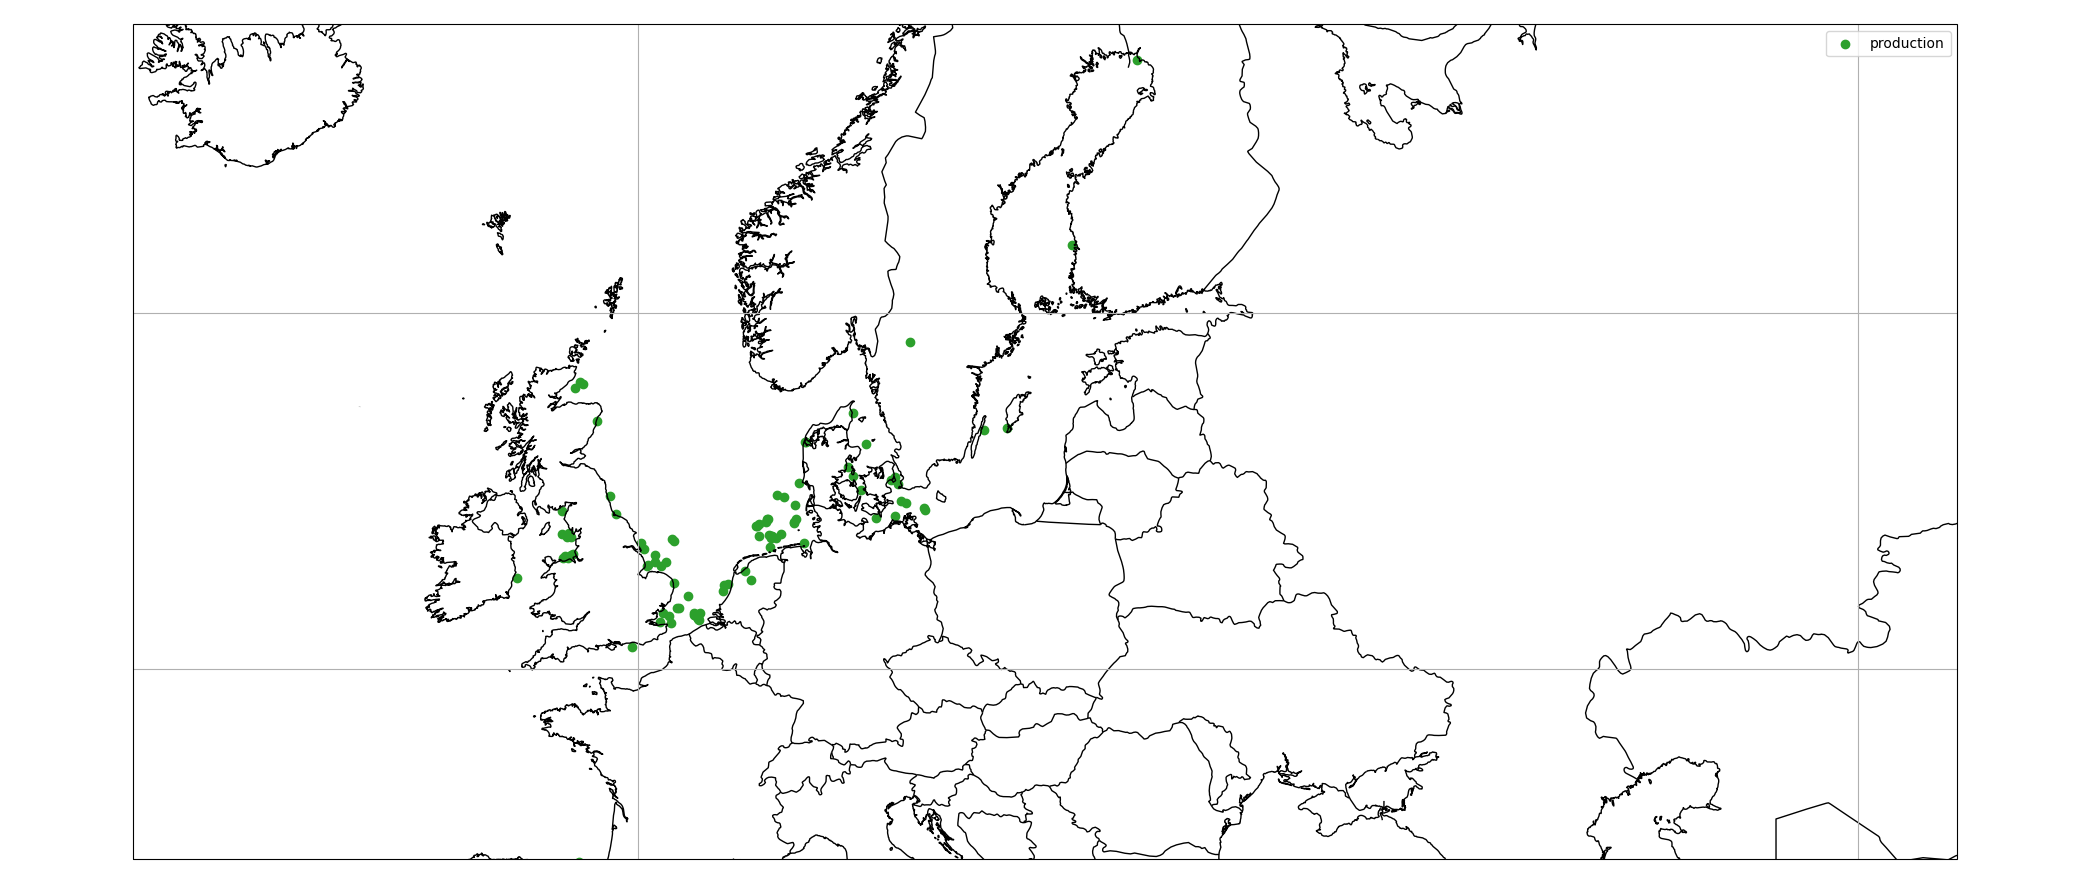

In [60]:
fig = plot_windfarms_cartopy(df_de[df_de.status=='production'], color='tab:green', label='production')
#plot_windfarms_cartopy(df_de[df_de.status=='planning'], color='tab:red', label='planning', fig=fig)
#plot_windfarms_cartopy(df_de[df_de.status=='commisioning'], color='tab:orange', label='commisioning', fig=fig)

In [53]:
len(df_de[df_de.status=="production"])

169

In [54]:
len(df_de)

260